In [ ]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-jqt9on6t
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-jqt9on6t
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

np.random.seed(123)

In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings_Beauty.csv', parse_dates=['Timestamp'])

In [ ]:
ratings

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200
...,...,...,...,...
2023065,A3DEHKPFANB8VA,B00LORWRJA,5.0,1405296000
2023066,A3DEHKPFANB8VA,B00LOS7MEE,5.0,1405296000
2023067,AG9TJLJUN5OM3,B00LP2YB8E,5.0,1405382400
2023068,AYBIB14QOI9PC,B00LPVG6V0,5.0,1405555200


In [ ]:
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
ratings['ProductId']= label_encoder.fit_transform(ratings['ProductId'])

ratings['UserId']= label_encoder.fit_transform(ratings['UserId'])
  
ratings['ProductId'].unique()
ratings['UserId'].unique()

array([ 725046,  814606,  313101, ..., 1030275,  249628,  841946])

In [ ]:
rand_userIds = np.random.choice(ratings['UserId'].unique(), 
                                size=int(len(ratings['UserId'].unique())*0.1), 
                                replace=False)

ratings = ratings.loc[ratings['UserId'].isin(rand_userIds)]


In [ ]:
ratings

,UserId,ProductId,Rating,Timestamp
9,660058,8,4.0,1389052800
30,1172629,19,1.0,1389657600
36,383615,19,5.0,1385251200
39,1070888,19,1.0,1399680000
41,591028,19,5.0,1397779200
...,...,...,...,...
2023024,679025,249264,5.0,1405641600
2023030,623691,249264,5.0,1405728000
2023037,103897,249264,5.0,1406073600
2023047,1203797,249265,3.0,1404950400


In [ ]:
ratings['rank_latest'] = ratings.groupby(['UserId'])['Timestamp'] \
                                .rank(method='first', ascending=False)

train_ratings = ratings[ratings['rank_latest'] != 1]
test_ratings = ratings[ratings['rank_latest'] == 1]

# drop columns that we no longer need
train_ratings = train_ratings[['UserId', 'ProductId', 'Rating']]
test_ratings = test_ratings[['UserId', 'ProductId', 'Rating']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_ratings.loc[:, 'rating'] = 1

train_ratings.sample(10)

,UserId,ProductId,Rating,rating
1802630,944913,199970,3.0,1
1130711,390612,107178,5.0,1
1150159,484151,110029,5.0,1
1499078,1036851,154000,1.0,1
1119948,358972,105813,5.0,1
1575581,462471,163440,4.0,1
1169173,287197,112303,5.0,1
604540,478331,52165,5.0,1
1296491,734432,127523,5.0,1
720221,45293,63446,5.0,1


In [ ]:
popular_products = pd.DataFrame(ratings.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(10)

,Rating
ProductId,
65766,757
10516,268
110873,239
41474,206
2365,203
105018,197
94769,192
43368,185
17629,162


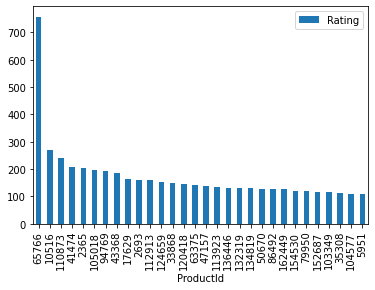

In [ ]:
most_popular.head(30).plot(kind = "bar")

In [ ]:
# Get a list of all ProductId IDs
all_ProductIds = ratings['ProductId'].unique()

# Placeholders that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each user has interaction with
user_item_set = set(zip(train_ratings['UserId'], train_ratings['ProductId']))

# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_ProductIds) 
        # check that the user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_ProductIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0) # items not interacted with are negative

  0%|          | 0/81650 [00:00<?, ?it/s]

In [ ]:
class TrainDataset(Dataset):
    """MovieLens PyTorch Dataset for Training
    
    Args:
        ratings (pd.DataFrame): Dataframe containing the movie ratings
        all_movieIds (list): List containing all movieIds
    
    """

    def __init__(self, ratings, all_ProductIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_ProductIds)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_ProductIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['UserId'], ratings['ProductId']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_ProductIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_ProductIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)


In [ ]:
class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """
    
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds
        
    def forward(self, user_input, item_input):
        
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(TrainDataset(self.ratings, self.all_movieIds),
                          batch_size=512, num_workers=4)

In [ ]:
num_users = ratings['UserId'].max()+1
num_items = ratings['ProductId'].max()+1

all_movieIds = ratings['ProductId'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)

trainer = pl.Trainer(max_epochs=5)

trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 9.7 M 
1 | item_embedding | Embedding | 2.0 M 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.718    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number o

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
# User-item pairs for testing
test_user_item_set = set(zip(test_ratings['UserId'], test_ratings['ProductId']))

# Dict of all items that are interacted with by each user
user_interacted_items = ratings.groupby('UserId')['ProductId'].apply(list).to_dict()

hits = []
for (u,i) in test_user_item_set:
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_ProductIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    
    predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())
    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))


The Hit Ratio @ 10 is 0.26


#### Model 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class NCF_2(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """
    
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds
        
    def forward(self, user_input, item_input):
        
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.Tanh()(self.fc1(vector))
        vector = nn.Tanh()(self.fc2(vector))
      

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(TrainDataset(self.ratings, self.all_movieIds),
                          batch_size=512, num_workers=4)

In [ ]:
num_users = ratings['UserId'].max()+1
num_items = ratings['ProductId'].max()+1

all_movieIds = ratings['ProductId'].unique()

model_2 = NCF_2(num_users, num_items, train_ratings, all_movieIds)

trainer = pl.Trainer(max_epochs=5)

trainer.fit(model_2)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 9.7 M 
1 | item_embedding | Embedding | 2.0 M 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.718    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
# User-item pairs for testing
test_user_item_set = set(zip(test_ratings['UserId'], test_ratings['ProductId']))

# Dict of all items that are interacted with by each user
user_interacted_items = ratings.groupby('UserId')['ProductId'].apply(list).to_dict()

hits = []
for (u,i) in test_user_item_set:
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_ProductIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    
    predicted_labels = np.squeeze(model_2(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())
    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))


The Hit Ratio @ 10 is 0.25


#### Model 3

In [ ]:
class NCF_3(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """
    
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds
        
    def forward(self, user_input, item_input):
        
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.Softmax()(self.fc1(vector))
        vector = nn.Softmax()(self.fc2(vector))
      

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(TrainDataset(self.ratings, self.all_movieIds),
                          batch_size=512, num_workers=4)

In [ ]:
num_users = ratings['UserId'].max()+1
num_items = ratings['ProductId'].max()+1

all_movieIds = ratings['ProductId'].unique()

model_3 = NCF_3(num_users, num_items, train_ratings, all_movieIds)

trainer = pl.Trainer(max_epochs=5)

trainer.fit(model_3)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 9.7 M 
1 | item_embedding | Embedding | 2.0 M 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.718    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
# User-item pairs for testing
test_user_item_set = set(zip(test_ratings['UserId'], test_ratings['ProductId']))

# Dict of all items that are interacted with by each user
user_interacted_items = ratings.groupby('UserId')['ProductId'].apply(list).to_dict()

hits = []
for (u,i) in test_user_item_set:
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_ProductIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    
    predicted_labels = np.squeeze(model_3(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())
    
    top20_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:20].tolist()]
    
    if i in top20_items:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


The Hit Ratio @ 10 is 0.32
